<a href="https://colab.research.google.com/github/brenoskuk/image_processing_exercises/blob/master/alzheimer_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alzheimer prediction using gray matter density from T1w MRI 

**Deadline**: Upload this notebook (rename it as 'TP4-IMA205-YOUR-SURNAME.ipynb') with your answers to the Site pédagogique before the 18th of March 2020 (23h59).

Please complete the code where you see XXXXXXXXXXXX and answer the questions.

We will use a dataset composed of neuroimaging features from brain T1w MR images of 752 subjects, 416 controls and 336 with Alzheimer’s disease. Following the pipeline described in [1], all images are first normalized to a
common space, providing a voxel-wise correspondence across subjects. Then, gray matter density is computed at each voxel and averaged over a set of ROIs (Region of Interest) of an atlas, at the beginning you will use the [AAL2 atlas](http://www.gin.cnrs.fr/en/tools/aal/). Data comes from several freely available datasets, like [ADNI](http://adni.loni.usc.edu/) and [OASIS](https://www.oasis-brains.org/), and has been pre-processed by the [Clinica](http://www.clinica.run/) team using the procedure explained in [1].

Please load the data from the file: *dataTP.npz* where *T1x* is a matrix containing the averaged density (each row is a subject and each column a feature), *y* is a vector containing the diagnosis (0 for controls and 1 for Alzheimer’s patients) and *ROIlabelsx* contains the name of the ROI of each feature. Here, *x* can take the name of the three atlases you have at your disposal: AAL2, [AICHA](http://www.gin.cnrs.fr/fr/outils/aicha/), [HAMMERS](https://brain-development.org/brain-atlases/adult-brain-atlases/).

**Reference**:
[1] J. Samper-González, N. Burgos, S. Bottani, S. Fontanella, P. Lu, A. Marcoux, A. Routier, J. Guillon, M. Bacci, J. Wen, A. Bertrand, H. Bertin, M.-O. Habert, S. Durrleman, T. Evgeniou, O. Colliot. *Reproducible evaluation of classification methods in Alzheimer's disease: framework and application to MRI and PET data*. NeuroImage, 2018 

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import warnings
warnings.filterwarnings('ignore', category=ImportWarning)

# Libraries
import numpy as np
import matplotlib.pyplot as plt
!pip install -q nilearn
from nilearn import plotting
%matplotlib inline
np.random.seed(seed=666)

from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='11cQmPm64k3T7ml5fPLetZgb1j1AjHBH8',
dest_path='./dataTP.npz')
gdd.download_file_from_google_drive(file_id='1S7e5IrPygE4VV0JTwqJIlyO2S_NhsiI4',
dest_path='./AtlasAAL2.nii')
gdd.download_file_from_google_drive(file_id='1E0pu5jIMpgcs2DQ8lBGWliwEBZvKrnV9',
dest_path='./AtlasAICHA.nii')
gdd.download_file_from_google_drive(file_id='1yltKwULrkHYh79RAh_zAg08r8pQMjRlQ',
dest_path='./AtlasHAMMERS.nii')

with np.load('./dataTP.npz',allow_pickle=True) as data:
    T1AAL2 = data['T1AAL2'] # data from AAL2 Atlas
    T1AICHA = data['T1AICHA'] # data from AICHA Atlas
    T1HAMMERS = data['T1HAMMERS'] # data from HAMMERS Atlas  
    y = data['y'] # classes, 0 for controls and 1 for patients    
    ROIlabelsAAL2 = data['ROIlabelsAAL2'] # labels for ROIs of atlas AAL2 
    ROIlabelsAICHA = data['ROIlabelsAICHA']    # labels for ROIs of atlas AICHA 
    ROIlabelsHAMMERS = data['ROIlabelsHAMMERS']    # labels for ROIs of atlas HAMMERS 

In [ ]:
# Choose Atlas (here AAL2)
X=T1AAL2
labels=ROIlabelsAAL2
atlas='./AtlasAAL2.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI is: {0}'.format(M))

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI is: 120


Using the library nilearn we can also plot the atlas used to define the ROIs:

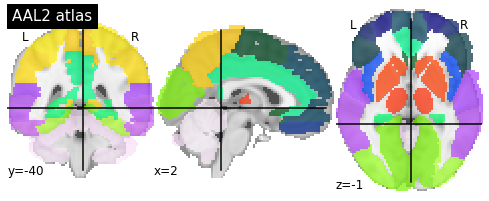

In [ ]:
plotting.plot_roi(atlas, title="AAL2 atlas")
plotting.show()

In this TP we will use Decision Trees, Bagging and Random Forests. Let's start with Decision Trees. First of all, we need to scale the features so that each feature will have average equal to 0 and unit variance and create a training and test set.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale data (each feature will have average equal to 0 and unit variance)

scaler = StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, np.ravel(y), test_size=0.33, random_state=42)


Then, we can fit a Decision tree, with the default setting, using the following code:

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# Fitting Decision Trees with maximum depth equal to 4 (to keep the output simple)
Tree = DecisionTreeClassifier(max_depth=4)
Tree.fit(X_train,y_train)
# Score in the training set
no_hyper_train = Tree.score(X_train,y_train)
print('Score in the training set is {0}'.format(no_hyper_train) )
# Score in the test set
no_hyper_test = Tree.score(X_test,y_test)
print('Score in the test set is {0}'.format(Tree.score(X_test,y_test)) )

Score in the training set is 0.8687872763419483
Score in the test set is 0.7389558232931727


Instead than using the default hyperparameters, we could also look for the best ones. Among the hyperparameters implemented in *scikit-learn* we could use *'min_samples_split'*, the minimum number of samples required to split an internal node, and/or *'min_samples_leaf'*, the minimum number of samples required to be present at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 

Plot the training and test score for different values of 'min_samples_split' (for instance between 1 and 10) WITHOUT using Cross Validation. Do the same for 'min_samples_leaf'. **Question:** What is the best value ? What happens if you split differently your data ? 

**Answer:** We search on the interval of 2 to 101 for min_samples_split, as it must be an integer greater than 1, and on the interval of 1 to 100 for min_samples_leaf. We see that the initial values for the graphics of both training sets starts at the same value when there no hyperparameters besides depth. As the number increases, we see that accuracy decreases for Training Data but starts attaining good results for Testing Data, as we are interested on testing unlabeled data, we can find good values for the hyperparameters by looking at arg max of the accuracy of Testing Data.

By varying the size of the set of testing data, and thus inversely changing the size of training, we obtain results that change. In the case of Min Samples Split we find that $65$ is a good hyperparameter for a good range of splits. In the case of Min Samples Leaf, using the same logic, we find the value of $60$. 

Result by splitting data by  0.03  for testing 


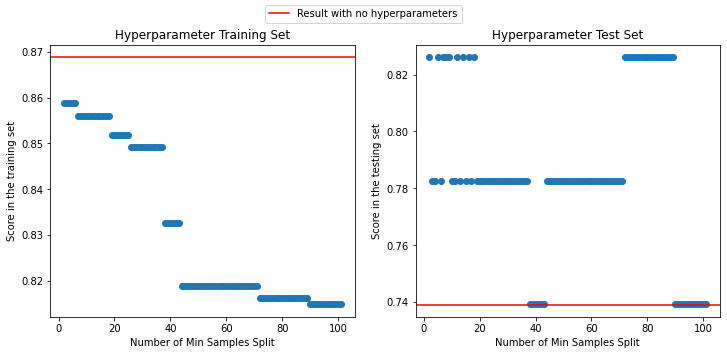

Result by splitting data by  0.13  for testing 


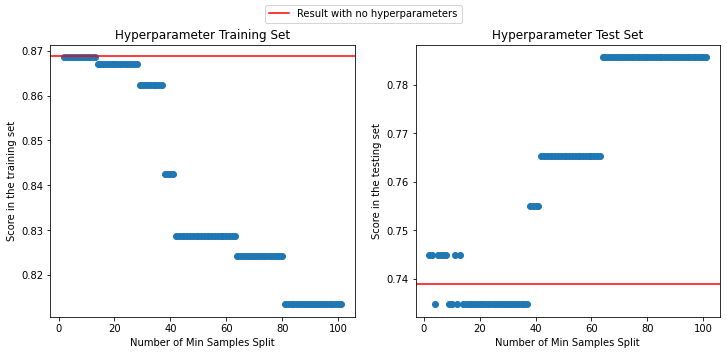

Result by splitting data by  0.23  for testing 


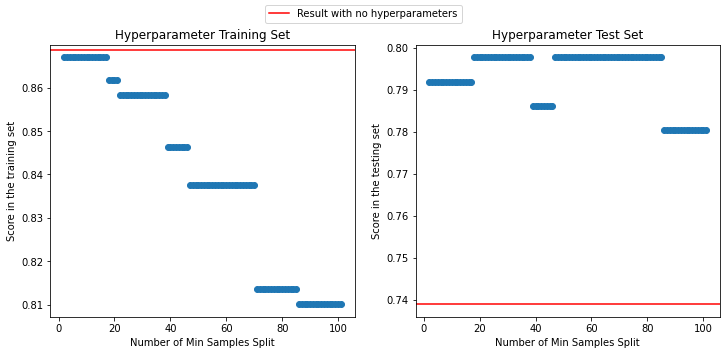

Result by splitting data by  0.33000000000000007  for testing 


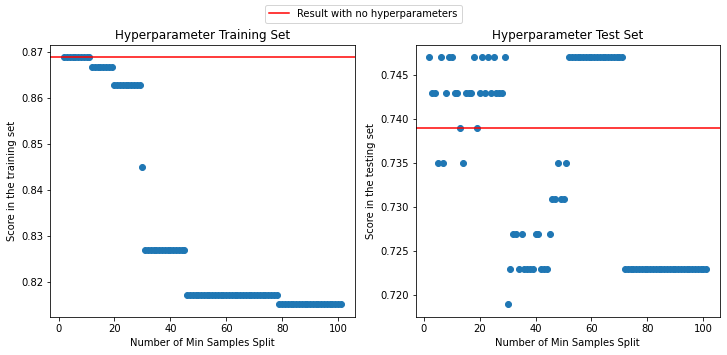

Result by splitting data by  0.43000000000000005  for testing 


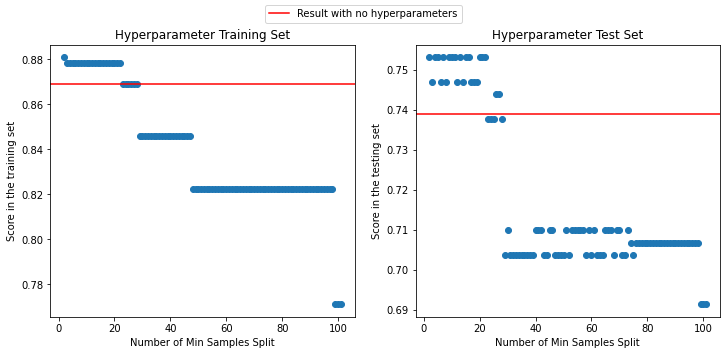

In [ ]:
# 'min_samples_split'
n = 100
TTest = np.zeros(n)
TTrain = np.zeros(n)

# changes size of test split
for j in range(5):
  print("Result by splitting data by ", 0.1*j+0.03, " for testing ")
  # Create training and test set
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, np.ravel(y), test_size=0.1*j + 0.03, random_state=42)
  for i in range(n):
    Tree = DecisionTreeClassifier(max_depth=4, min_samples_split = i + 2)
    Tree.fit(X_train,y_train)
    # Score in the training set
    TTrain[i] = Tree.score(X_train,y_train)
    # Score in the test set
    TTest[i] = Tree.score(X_test,y_test)


  # plotting
  f = plt.figure(figsize=(12,5))

  ax = f.add_subplot(121)
  plt.plot([i+2 for i in range(n)], TTrain, linestyle='None', marker='o')
  line_train = plt.axhline(y=no_hyper_train, label = 'Result with no hyperparameters', color='r', linestyle='-')
  plt.title("Hyperparameter Training Set")
  plt.xlabel("Number of Min Samples Split")
  plt.ylabel("Score in the training set")
  ax2 = f.add_subplot(122)
  plt.plot([i+2 for i in range(n)], TTest, linestyle='None', marker='o')
  plt.axhline(y=no_hyper_test, label = 'Result with no hyperparameters', color='r', linestyle='-')
  plt.title("Hyperparameter Test Set")
  plt.xlabel("Number of Min Samples Split")
  plt.ylabel("Score in the testing set")


  handles, labels_graphs = ax.get_legend_handles_labels()
  f.legend(handles, labels_graphs, loc='upper center')

  plt.show()

Result by splitting data by  0.03  for testing 


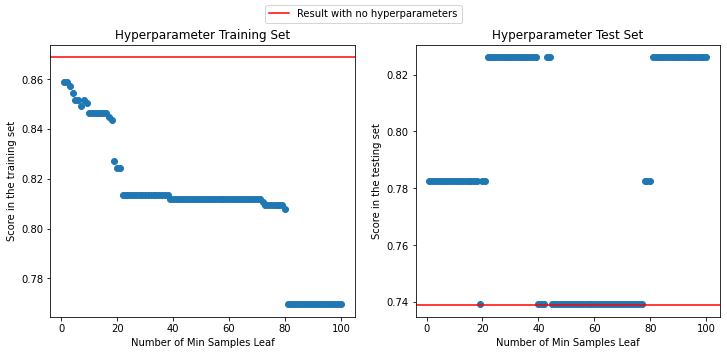

Result by splitting data by  0.13  for testing 


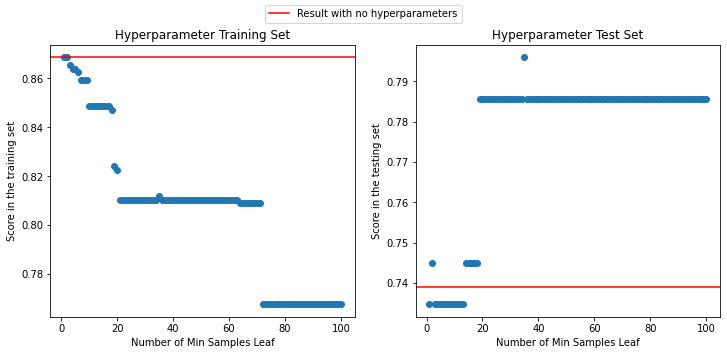

Result by splitting data by  0.23  for testing 


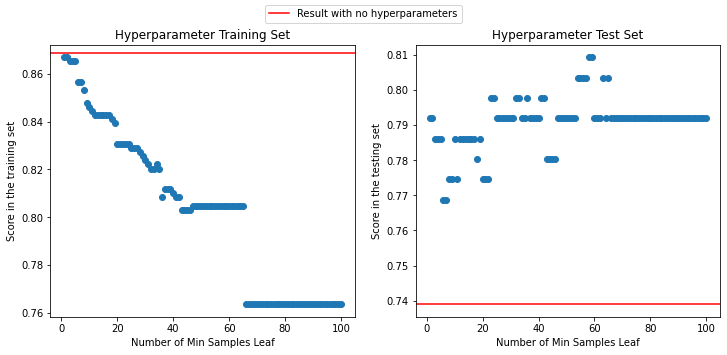

Result by splitting data by  0.33000000000000007  for testing 


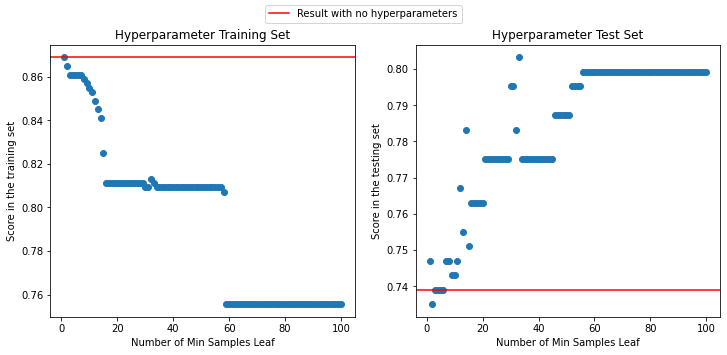

Result by splitting data by  0.43000000000000005  for testing 


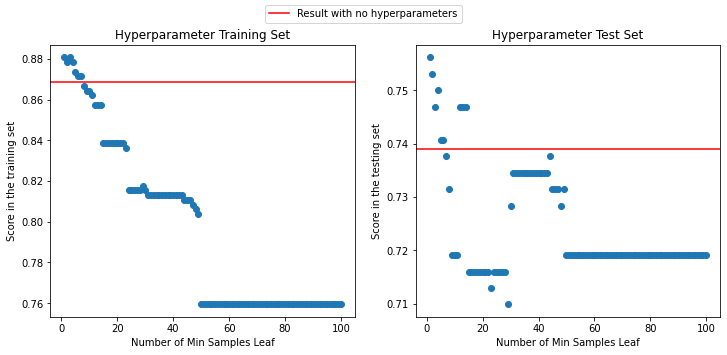

In [ ]:
# 'min_samples_leaf'
n = 100

TTest2 = np.zeros(n)
TTrain2 = np.zeros(n)
# changes size of test split
for j in range(5):
  print("Result by splitting data by ", 0.1*j+0.03, " for testing ")
  # Create training and test set
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, np.ravel(y), test_size=0.1*j + 0.03, random_state=42)
  for i in range(n):
    Tree2 = DecisionTreeClassifier(max_depth=4, min_samples_leaf = i + 1)
    Tree2.fit(X_train,y_train)
    # Score in the training set
    TTrain2[i] = Tree2.score(X_train,y_train)
    # Score in the test set
    TTest2[i] = Tree2.score(X_test,y_test)


  # plotting
  f = plt.figure(figsize=(12,5))

  ax = f.add_subplot(121)
  plt.plot([i+1 for i in range(n)], TTrain2, linestyle='None', marker='o')
  line_train = plt.axhline(y=no_hyper_train, label = 'Result with no hyperparameters', color='r', linestyle='-')
  plt.title("Hyperparameter Training Set")
  plt.xlabel("Number of Min Samples Leaf")
  plt.ylabel("Score in the training set")
  ax2 = f.add_subplot(122)
  plt.plot([i+1 for i in range(n)], TTest2, linestyle='None', marker='o')
  plt.axhline(y=no_hyper_test, label = 'Result with no hyperparameters', color='r', linestyle='-')
  plt.title("Hyperparameter Test Set")
  plt.xlabel("Number of Min Samples Leaf")
  plt.ylabel("Score in the testing set")

  handles, labels_graphs = ax.get_legend_handles_labels()
  f.legend(handles, labels_graphs, loc='upper center')

  plt.show()

Try to add Gaussian noise to the data (using for instance zero mean and 0.5 for the std) and, using the best hyperparameters found before, look at the test score. Repeat this process several times (at least 100 times) and compare the results with the score obtained without adding noise. **Question:** Are the results stable ? Hint: you could use for instance *noise = np.random.normal(mu, sigma)*

**Answer:** No. Results are clearly not stable. This makes sense since finding the tree is a greedy search, and thus small changes, such as noise can give very different outcomes.

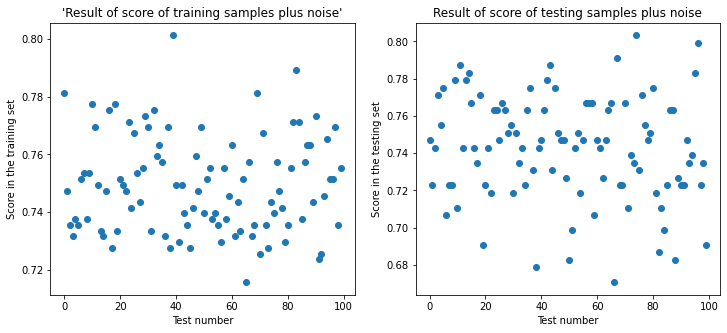

In [ ]:
n = 100
scoreTraining = np.zeros(n)
scoreTesting = np.zeros(n)
for i in range(n):
  # generating the noise
  noise = np.random.normal(0,0.5,(X_scaled.shape))
  # splitting in training and testing set
  X_train, X_test, y_train, y_test = train_test_split(X_scaled + noise, np.ravel(y), test_size=0.33, random_state=42)
  # using hyperparameters found before we test the Tree
  Tree = DecisionTreeClassifier(max_depth=4, min_samples_split = 65 ,min_samples_leaf = 70)
  Tree.fit(X_train,y_train)
  # Score in the training set
  scoreTraining[i] = Tree.score(X_train,y_train)
  # Score in the test set
  scoreTesting[i] = Tree.score(X_test,y_test)

# plotting
f = plt.figure(figsize=(12,5))

ax = f.add_subplot(121)
plt.plot([i for i in range(n)], scoreTraining, linestyle='None', marker='o')
plt.title("'Result of score of training samples plus noise'")
plt.xlabel("Test number")
plt.ylabel("Score in the training set")
ax2 = f.add_subplot(122)
plt.plot([i for i in range(n)], scoreTesting, linestyle='None', marker='o')
plt.title("Result of score of testing samples plus noise")
plt.xlabel("Test number")
plt.ylabel("Score in the testing set")
plt.show()

To plot decision trees, we can also use the *graphviz* library. If you need to install it locally, you can do it using *conda install python-graphviz*. 
 

First plot the tree learnt on the original data, witout adding noise.

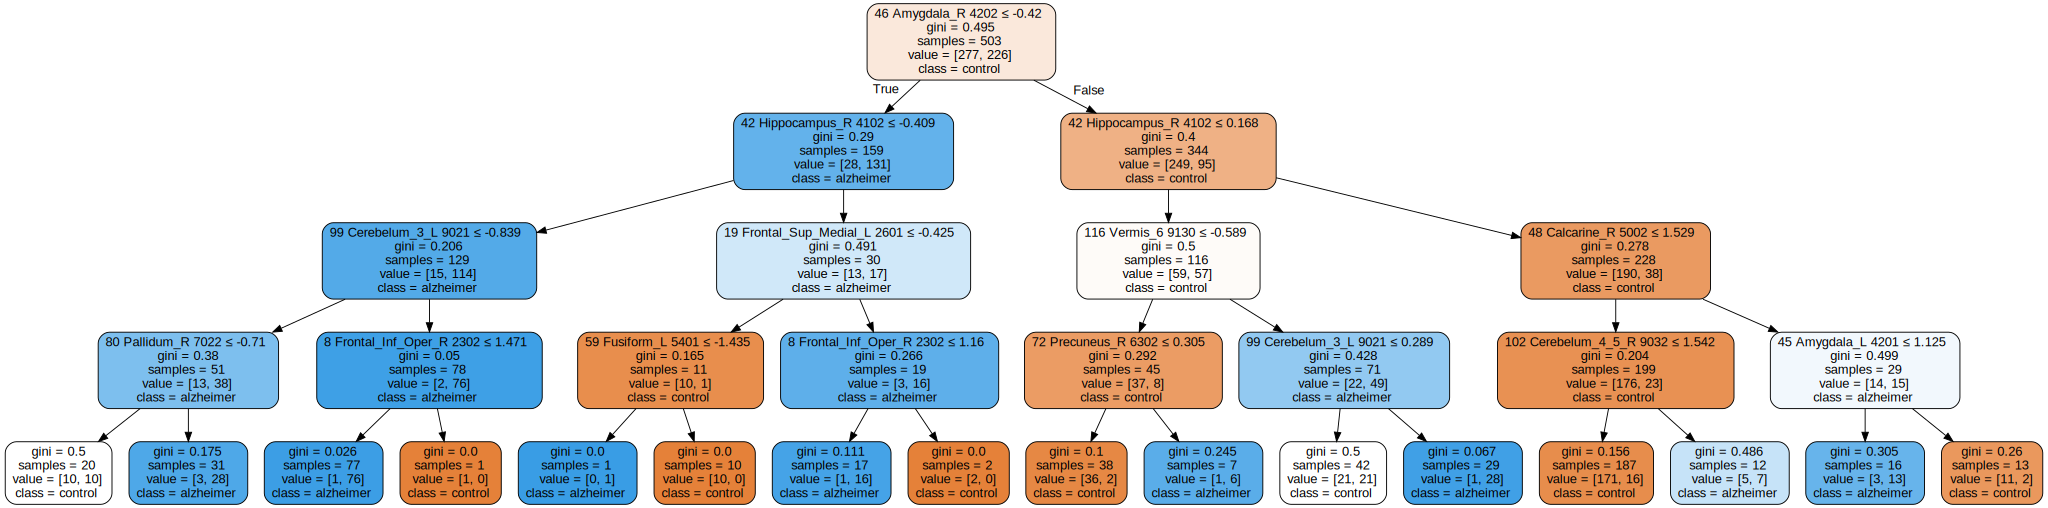

In [ ]:
import graphviz 

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, np.ravel(y), test_size=0.33, random_state=42)
Tree = DecisionTreeClassifier(max_depth=4)
Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Now, plot the tree learnt on noisy data. **Question:** Is it the same ? You can try several times, for different levels of noise. Comment the results.

**Answer:** The trees found with added noise are different than the one found without noise. This, as previously stated, is a consequence of the algorithm for finding the tree being a greedy one. What we perceive seeing the tree is that for small values of noise (like 0.01), the tree resembles the one without it. As the noise increases, the tree becomes more and more distant.

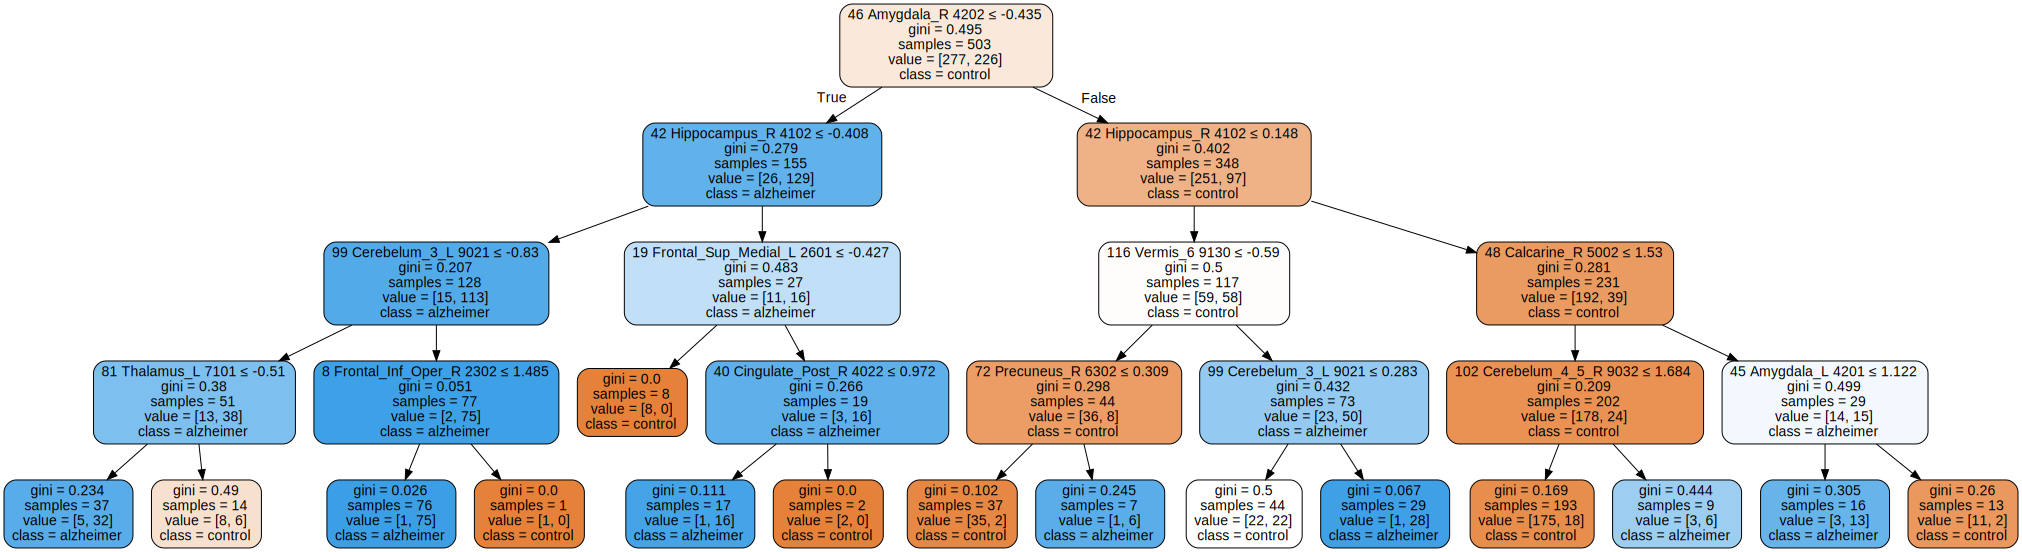

In [ ]:
noise = np.random.normal(0,0.01,(X_scaled.shape))
# splitting in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled + noise, np.ravel(y), test_size=0.33, random_state=42)
Tree = DecisionTreeClassifier(max_depth=4)

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Instead than using a single split of the data, we could also use Cross Validation to compute the best hyperparameter values for both 'min_samples_split' and 'min_samples_leaf' at the same time and in an automatic way. **Question:** Do you find the same optimal hyperparameters as before ? Hint: use GridSearchCV

**Answer**: For a grid search with depth equal to 40, the hyperparameters are never going to be the same, since they were found to be higher than that. However, if we search individually, the hyperparameters are very close to what was previously found. 

In [ ]:
from sklearn.model_selection import GridSearchCV
n=80

# Looking for the best min_samples_split
parameters = {'min_samples_split':[i for i in range(n)]}
Tree = DecisionTreeClassifier(max_depth=4)
grid = GridSearchCV(Tree, parameters, cv=5, n_jobs=-1)
grid.fit(X_scaled, np.ravel(y))

print('The best min_samples_split is', grid.best_params_.get('min_samples_split'), ' with an average validation score equal to ', grid.best_score_)

parameters = {'min_samples_leaf':[i for i in range(n)]}

# Looking for the best min_samples_leaf
parameters = {'min_samples_leaf':[i for i in range(n)], 'min_samples_leaf':[i for i in range(n)]}
Tree = DecisionTreeClassifier(max_depth=4)
grid = GridSearchCV(Tree, parameters, cv=5, n_jobs=-1)
grid.fit(X_scaled, np.ravel(y))

print('The best min_samples_leaf is', grid.best_params_.get('min_samples_leaf'), ' with an average validation score equal to ', grid.best_score_)

# Looking for the two hyperparameters at the same time (shallower search)
n = 40
parameters = {'min_samples_split':[i for i in range(n)], 'min_samples_leaf':[i for i in range(n)]}
Tree = DecisionTreeClassifier(max_depth=4)
grid = GridSearchCV(Tree, parameters, cv=5, n_jobs=-1)
grid.fit(X_scaled, np.ravel(y))

print('The best pair is \nmin_samples_leaf =', grid.best_params_.get('min_samples_leaf'),'\nmin_samples_split is', grid.best_params_.get('min_samples_split'),'\nwith an average validation score equal to ', grid.best_score_)


The best min_samples_split is 64  with an average validation score equal to  0.7580044150110377
The best min_samples_leaf is 38  with an average validation score equal to  0.7766004415011037
The best pair is 
min_samples_leaf = 12 
min_samples_split is 17 
with an average validation score equal to  0.776635761589404


Using the optimal hyperparameers, plot again the decision tree using the *graphviz* library. **Question:** Is it the same ? Do you see ROIs that are always present nearby the root of the trees ? Comment the results.

**Answer:** No. The trees are not the same. However we can see that there are features that seem to be important. For instance some of the ROIs that appear in both trees areccAmygdala_R 4202 and Hippocampus_R 4102. These repetitions seem to be more visible the less deep they are on the tree, as it indicate they result on an important reduction of impurity.

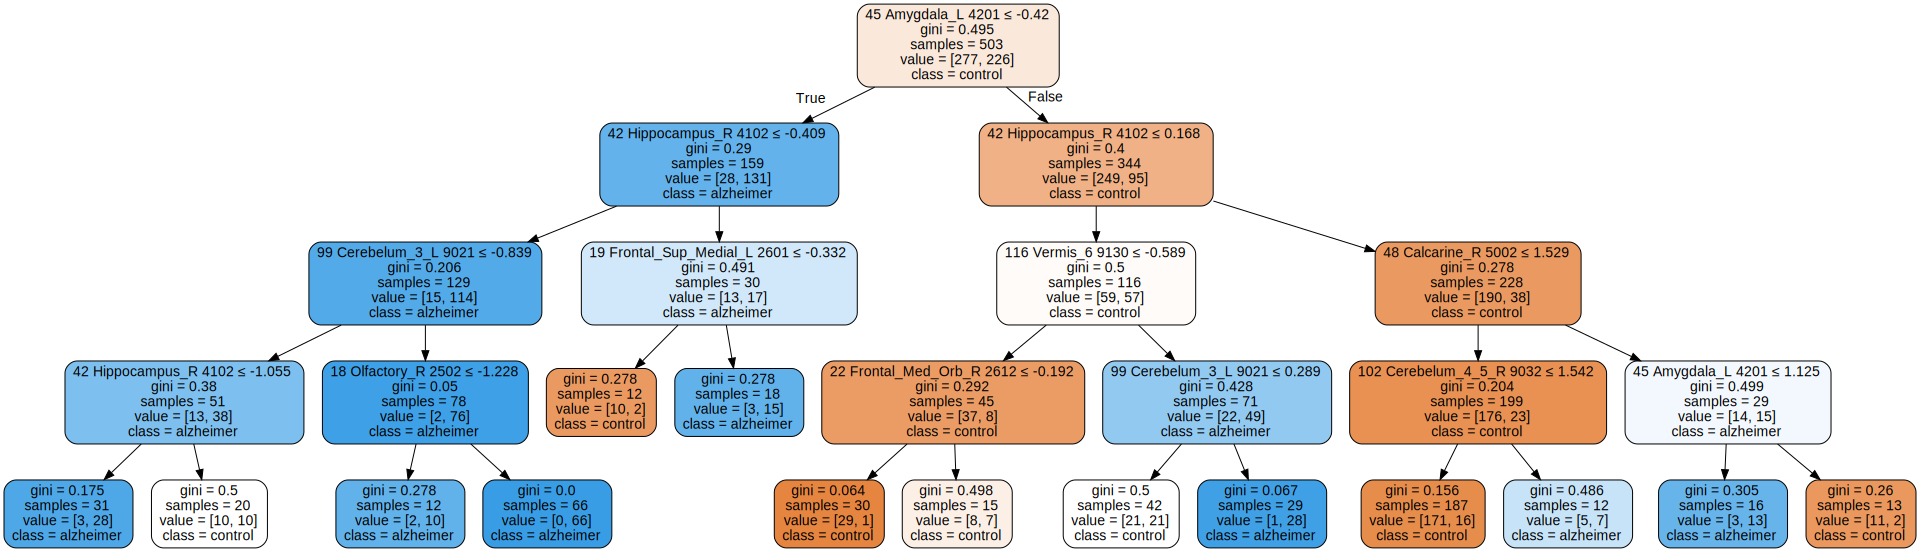

In [ ]:
# splitting in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, np.ravel(y), test_size=0.33, random_state=42)
Tree = DecisionTreeClassifier(max_depth=4, min_samples_split = 3 ,min_samples_leaf = 12)

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

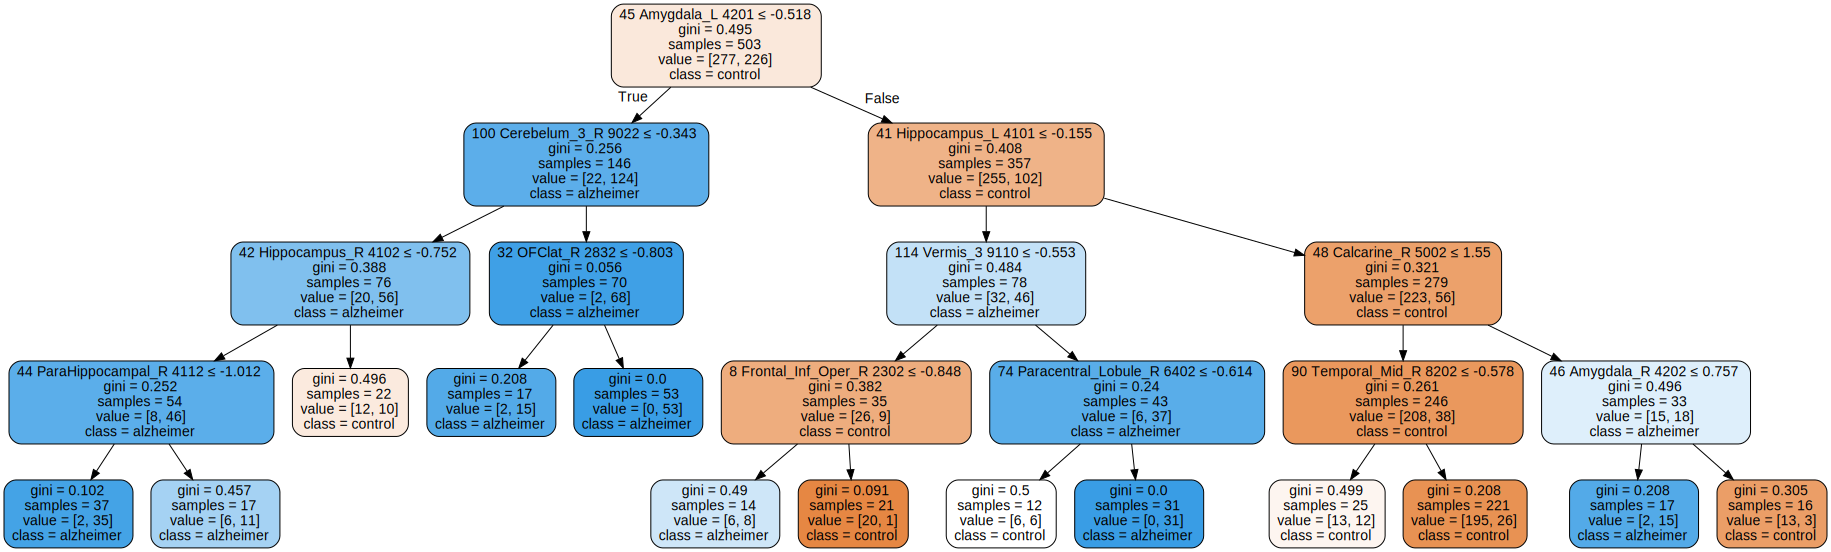

In [ ]:
noise = np.random.normal(0,0.1,(X_scaled.shape))
# splitting in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled + noise, np.ravel(y), test_size=0.33, random_state=42)
Tree = DecisionTreeClassifier(max_depth=4, min_samples_split = 3 ,min_samples_leaf = 12)

Tree.fit(X_train,y_train)
dot_data = tree.export_graphviz(Tree, out_file=None,feature_names=labels,class_names=class_names,filled=True, rounded=True,special_characters=True)
graph = graphviz.Source(dot_data)
graph

Try to use now Bagging. You can use the following code where we use the previously computed best parameters 'min_samples_leaf' and 'min_samples_split'. **Question:** What happens when you use the original data and the noisy version ? Do you notice any difference in the prediction scores with respect to the results using Decision Trees ? 

**Answer:** Bagging seems to be more robust and generate better scores on testing in comparison to the standard single tree algorithm, but it still generates different results when noise is added. It's interesting to add that accuracy increases in testing in some cases test accuracy is much higher than in training. This happened previously but seems to happen more here.

In [ ]:
from sklearn.ensemble import BaggingClassifier

Tree = DecisionTreeClassifier(criterion="gini",min_samples_leaf=3,min_samples_split=12, random_state=0)

p_grid_bagging = {'n_estimators': [5,10,15,20]}      
bag=BaggingClassifier(base_estimator=Tree, random_state=0)
grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
grid_bagging.fit(X_train, y_train)
print("Best Score: {}".format(grid_bagging.best_score_))
print("Best params: {}".format(grid_bagging.best_params_))
print("Bagging score :",grid_bagging.score(X_test,y_test))

Best Score: 0.7953861386138614
Best params: {'n_estimators': 15}
Bagging score : 0.8433734939759037


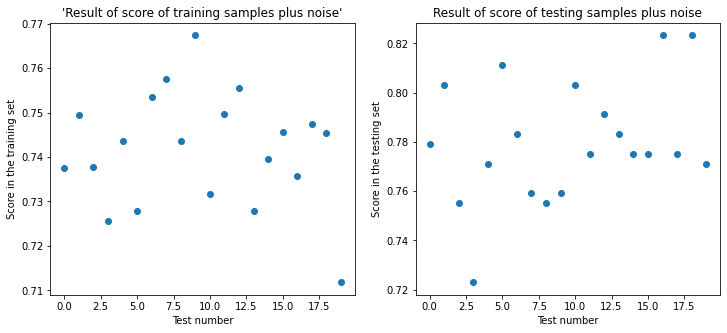

In [ ]:
Tree = DecisionTreeClassifier(criterion="gini",min_samples_leaf=12,min_samples_split=64, random_state=0)

# generating the noise
noise = np.random.normal(0,0.5,(X_scaled.shape))
# splitting in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled + noise, np.ravel(y), test_size=0.33, random_state=42)


n = 20
scoreTraining = np.zeros(n)
scoreTesting = np.zeros(n)
for i in range(n):
  # generating the noise
  noise = np.random.normal(0,0.5,(X_scaled.shape))
  # splitting in training and testing set
  X_train, X_test, y_train, y_test = train_test_split(X_scaled + noise, np.ravel(y), test_size=0.33, random_state=42)
  # using hyperparameters found before we test the Tree
  p_grid_bagging = {'n_estimators': [5,10,15,20]}      
  bag=BaggingClassifier(base_estimator=Tree, random_state=0)
  grid_bagging = GridSearchCV(estimator=bag, param_grid=p_grid_bagging, scoring="accuracy", cv=5)
  grid_bagging.fit(X_train, y_train)
  # Score in the training set
  scoreTraining[i] = grid_bagging.best_score_
  # Score in the test set
  scoreTesting[i] = grid_bagging.score(X_test,y_test)

# plotting
f = plt.figure(figsize=(12,5))

ax = f.add_subplot(121)
plt.plot([i for i in range(n)], scoreTraining, linestyle='None', marker='o')
plt.title("'Result of score of training samples plus noise'")
plt.xlabel("Test number")
plt.ylabel("Score in the training set")
ax2 = f.add_subplot(122)
plt.plot([i for i in range(n)], scoreTesting, linestyle='None', marker='o')
plt.title("Result of score of testing samples plus noise")
plt.xlabel("Test number")
plt.ylabel("Score in the testing set")
plt.show()


The last part of this TP is about Random Forests. We can estimate the three hyperparameters *'n_estimators'*, *'min_samples_leaf'* and *'max_features'*, the number of features to consider when looking for the best split, as before using Cross Validation

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Score: 0.7573861386138614
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 30}


**Question:** Using the estimated best hyperparameters, test the performance of Random Forest on the noisy data and compare the results with Decision Trees and Bagging. 

**Answer:** Random Forest is more robust to noise and produces better scores with and without noise when compared to the Decision Tree and to to the Bagging method. With data without noise the Random Forest and the Bagging method had similar results.

In [ ]:
# generating the noise
noise = np.random.normal(0,0.5,(X_scaled.shape))
# splitting in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled + noise, np.ravel(y), test_size=0.33, random_state=42)

RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

Best Score: 0.7653069306930693
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 25}


We can also use Random Forests to check the importance of the features

Feature ranking:
1. feature 41 representing 42 Hippocampus_R 4102
 (0.056569)
2. feature 40 representing 41 Hippocampus_L 4101
 (0.053792)
3. feature 43 representing 44 ParaHippocampal_R 4112
 (0.044849)
4. feature 45 representing 46 Amygdala_R 4202
 (0.044041)
5. feature 92 representing 93 Temporal_Inf_L 8301
 (0.030855)
6. feature 44 representing 45 Amygdala_L 4201
 (0.026522)
7. feature 93 representing 94 Temporal_Inf_R 8302
 (0.025194)
8. feature 47 representing 48 Calcarine_R 5002
 (0.024196)
9. feature 88 representing 89 Temporal_Mid_L 8201
 (0.022705)
10. feature 42 representing 43 ParaHippocampal_L 4111
 (0.019555)


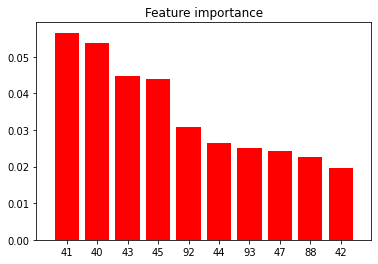

In [ ]:
best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Question:** Which are the most important features (i.e. ROIs) ?  Based on the two given research papers, you can verify if your results make sense. 


**Answer:** The most important features are 
ParaHippocampal_R 4112
Hippocampus_L 4101
Amygdala_L 4201
Amygdala_R 4202

As we can read in the papers, these are regions that are greatly affected by Alzheimers disease, as we can read here:

"[...]It has been suggested that automated feature selection will not
improve classification accuracy as compared to biologically informed
feature selection, driven by prior biological knowledge of regions
typically affected by AD, such as the hippocampus, amygdala, thalamus, and caudate."

It's also interesting to note that Amygdala_L 4201 appears as the root node a number of times on the previously plotted trees.

We can also inspect the data using only pairs of the most important features

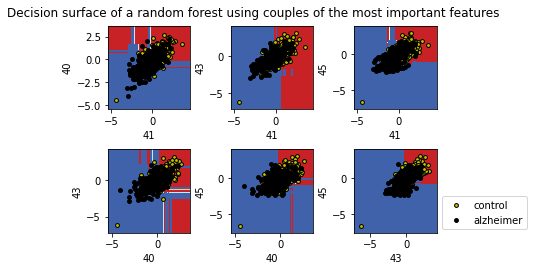

In [ ]:
for pairidx, pair in enumerate([ [indices[0],indices[1]], [indices[0],indices[2]], [indices[0],indices[3]],
                                [indices[1],indices[2]], [indices[1],indices[3]], [indices[2],indices[3]] ]):
    # We only take the two corresponding features
    Xpair = X_train[:, pair]
    ypair = y_train

    # Train
    clf = RF.fit(Xpair, ypair)

    # Plot the decision boundary
    plt.subplot(2, 3, pairidx + 1)

    x_min, x_max = Xpair[:, 0].min() - 1, Xpair[:, 0].max() + 1
    y_min, y_max = Xpair[:, 1].min() - 1, Xpair[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)

    plt.xlabel(pair[0])
    plt.ylabel(pair[1])

    # Plot the training points
    for i, color in zip(range(2), "yk"):
        idx = np.where(ypair == i)
        plt.scatter(Xpair[idx, 0], Xpair[idx, 1], c=color, label=class_names[i],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)

plt.suptitle("Decision surface of a random forest using couples of the most important features")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.axis("tight")
plt.show()

**Question:** Which is the best couple of features ?

**Answer:** Features is the (43,45), seem to  it be more well segmented from the rest, where little variations won't change the outcome of the classification. This is useful since we are interested adding more features to the model it will be more simple.



**Different Atlas**

Previously, we have used the AAL2 which defines a precise split of the brain into ROIs.
**Question:** What happens if you change Atlas ? Do you obtain the same results ? Can you find a subset of ROIs that you could define 'biomarkers' of the Alzheimer's disease ? Justify your answer and check whether it makes sense by using the two given research papers.

You can use the AICHA (http://www.gin.cnrs.fr/fr/outils/aicha/) and HAMMERS (https://brain-development.org/brain-atlases/adult-brain-atlases/) atlas.


**Answer**: HAMMERS Atlas has less features while AICHA has a larger number. Both Atlas provide good results if we apply the Forest method. 

Given the best features of the 3 different Atla, it's feasible to define a subset of 'biomarkers' of the Alzheimer disease, however, as the ROIs of each ATLAS are different, it's not possible to just set a set of standard features to analyse. 

As previously stated, the articles say that in general the hippocampus and amygdala regions are the most affected by the disease, and thus are more likely to carry relevant information as features, as we can see in the following text, as well as in the one on the previous question.


"The clinical use of structural MRI in Alzheimer disease which supports our conclusions: 'The presence of atrophy of medial temporal structures is a partially validated candidate marker for early diagnosis of the disease at the MCI stage. Rates of whole-brain and hippocampal atrophy are sensitive and powerful markers of progression of neurodegeneration and, as a result, are increasingly used, along with clinical metrics, as outcomes in clinical trials of potential disease-modifying therapies.'"

This indicates that features that describe these areas can be viwed as good 'biomarkers'

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI is: 192
Best Score: 0.7652871287128714
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 15}
Feature ranking:
1. feature 144 representing 145	S_Parietooccipital-4	146
 (0.081293)
2. feature 173 representing 174	N_Caudate-1	175
 (0.037795)
3. feature 187 representing 188	N_Thalamus-5	189
 (0.030753)
4. feature 145 representing 146	S_Parietooccipital-5	147
 (0.025472)
5. feature 170 representing 171	G_Fusiform-6	172
 (0.025103)
6. feature 189 representing 190	N_Thalamus-7	191
 (0.024759)
7. feature 74 representing 75	G_Insula-anterior-3	76
 (0.024081)
8. feature 182 representing 183	N_Putamen-3	184
 (0.021630)
9. feature 143 representing 144	S_Parietooccipital-3	145
 (0.019331)
10. feature 172 representing 173	N_Amygdala-1	174
 (0.018985)


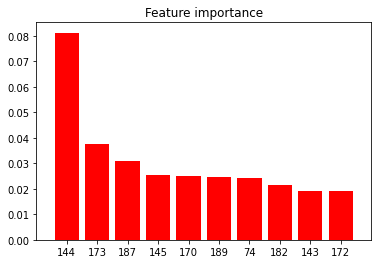

In [ ]:
# Choose Atlas (here AICHA)
X=T1AICHA
labels=ROIlabelsAICHA
atlas='./AtlasAICHA.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI is: {0}'.format(M))

# Scale data (each feature will have average equal to 0 and unit variance)

scaler = StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)

# splitting in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled , np.ravel(y), test_size=0.33, random_state=42)

RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

Number of controls and Alzheimer patients is respectively: 416.0 and 336.0
Number of ROI is: 68
Best Score: 0.8031881188118813
Best params: {'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 25}
Feature ranking:
1. feature 3 representing Right Amygdala                         (0.108175)
2. feature 2 representing Left Amygdala                          (0.069019)
3. feature 0 representing Left Hippocampus                       (0.065490)
4. feature 46 representing Left Lateral Temporal Ventricle        (0.051720)
5. feature 47 representing Right Lateral Temporal Ventricle       (0.047733)
6. feature 1 representing Right Hippocampus                      (0.046961)
7. feature 12 representing Left Inferior Middle Temporal Gyri     (0.031342)
8. feature 8 representing Left Ambient and Parahippocampus Gyri  (0.026882)
9. feature 40 representing Left Thalamus                          (0.019667)
10. feature 45 representing Right Corpus Callosum                  (0.018714)


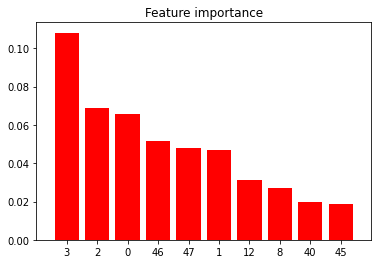

In [ ]:
# Choose Atlas (here AICHA)
X=T1HAMMERS
labels=ROIlabelsHAMMERS
atlas='./AtlasHAMMERS.nii'

N,M = X.shape # number subjects and ROIs
class_names = ["control","alzheimer"] # y=0, y=1

print('Number of controls and Alzheimer patients is respectively: {0} and {1}'.format(N-np.sum(y), np.sum(y)))
print('Number of ROI is: {0}'.format(M))

# Scale data (each feature will have average equal to 0 and unit variance)

scaler = StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)

# splitting in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled , np.ravel(y), test_size=0.33, random_state=42)

RF=RandomForestClassifier(criterion="gini", random_state=0)
p_grid_RF = {'n_estimators': [10,15,20,25,30], 'min_samples_leaf': [2,3,4,5,6], 'max_features': ['sqrt','log2']}   

grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF, scoring="accuracy", cv=5)
grid_RF.fit(X_train, y_train)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

best_params=grid_RF.best_params_
RF = RandomForestClassifier(criterion="gini",min_samples_leaf=best_params["min_samples_leaf"],max_features=best_params["max_features"],n_estimators=best_params["n_estimators"], random_state=0)
RF.fit(X_train,y_train)

importances = RF.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d representing %s (%f)" % (f + 1, indices[f], labels[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(10), importances[indices[0:10]], color="r", align="center")
plt.xticks(range(10), indices[0:10])
plt.xlim([-1, 10])
plt.show()

**Theoretical Questions**

**Question:** Please answer the two questions at slide 28 and 31 writing here the computations.

**Slide 28**

It follows that the second cut has more reduction of entropy for the same number of points, and so is better. This was surely going to happen since the number of questions needed to correctly classify a point is smaller than in the first cut. 

In [ ]:
import math

# Code to compute slide 28

def entropy_k2(p):
  return -p*math.log2(p) - (1-p)*math.log2(1-p)

L1 = 1/2*(entropy_k2(1/4)) + 1/2*(entropy_k2(1/4))
L2 = 1/2*(entropy_k2(1/3))

print("L1 = ",  L1, "\nL2 =", L2 )

L1 =  0.8112781244591328 
L2 = 0.4591479170272448


**Slide 31**

The answer remains the same as in the previous question.

In [ ]:
# Code to compute slide 31

def gini_k2(p):
  return 2*p*(1-p)

L1 = 1/2*(gini_k2(1/4)) + 1/2*(gini_k2(1/4))
L2 = 1/2*(gini_k2(1/3))

print("L1 = ",  L1, "\nL2 =", L2 )

L1 =  0.375 
L2 = 0.22222222222222224
